In [1]:
# ---- Default values for plots ----
title_fontsize = 16
label_fontsize = 12
tick_fontsize = 10

fig_length = 12

letters = ['(a)', '(b)', '(c)', '(d)']

In [3]:
# ---- imports ----
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# ---- functions ----
def parse_model(model_name):
    # Regex to extract the network type and dimension
    match = re.match(r"([a-zA-Z_]+)(\d+|[a-zA-Z_]+)", model_name)
    if match:
        net_type, dimension = match.groups()
        # Convert the dimension to an integer if it's a number
        if dimension.isdigit():
            dimension = int(dimension)
        else:
            # Assign a value based on the predefined size order
            dimension = size_order.get(dimension, dimension)
        return net_type, dimension
    return model_name, 0

In [ ]:
# ------ Main Fig. 3 ------

title_fontproperties = {'size': label_fontsize, 'weight': 'bold'}
size_order = {'s': 1, 'm': 2, 'l': 3, 'h': 4}
legend_titles = ['Test split', 'Test plate', 'Train plate', 'Test plate']
plot_titles = ['Batch-stratified', 'Batch-separated', 'Single Plate', 'Reduced']


df1 = pd.read_csv('../data/Experiment1_BatchStratified.csv', sep='\t')
df2 = pd.read_csv('../data/Experiment1_BatchSeparated.csv', sep='\t')
df3 = pd.read_csv('../data/Experiment1_SinglePlate.csv', sep='\t')
df4 = pd.read_csv('../data/Experiment1_Reduced.csv', sep='\t')
dfs = [df1, df2, df3, df4]


x_ticks = df1['model'].unique()
x_ticks = sorted(x_ticks, key=lambda x: (parse_model(x)[0], parse_model(x)[1]))

groups = sorted(df1['split'].unique())
n_groups = len(groups)
width = 1 / (n_groups + 2)  # the width of the bars

fig, ax = plt.subplots(2, 2, figsize=(fig_length, 8))

for i in range(len(dfs)):
    df_s = dfs[i]
    multiplier = 0
    x = np.arange(len(x_ticks))  # the label locations
    for group in groups:
        means = []
        errs = []
        offset = width * multiplier + width / 2
        for tick in x_ticks:
            tick_df = df_s[(df_s['model'] == tick) & (df_s['split'] == group)]
            m = tick_df['mean'].values[0]
            s = tick_df['std'].values[0]
            means.append(m)
            errs.append(s)
        label_name = f"{group}"
        ax[i//2, i%2].bar(x + offset, means, width, yerr=errs, label=label_name, alpha=0.8)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    if i//2 == 1:
        ax[i//2, i%2].set_xticks(x + (width * n_groups) / 2, x_ticks, rotation=60, fontsize=tick_fontsize)
    else:
        ax[i//2, i%2].set_xticks([], [])
    if i%2 == 0:
        ax[i//2, i%2].set_ylabel('F1 score', fontsize=label_fontsize)

    ax[i//2, i%2].tick_params(axis='y', labelsize=tick_fontsize)
    ax[i//2, i%2].text(-0.05, 1.05, letters[i], transform=ax[i//2, i%2].transAxes, size=16, weight='bold')
    ax[i//2, i%2].axhline(y=0.9, color='k', linestyle='--')
    ax[i//2, i%2].set_ylim([0.5, 1.05])

    ax[i//2, i%2].set_title(plot_titles[i], fontsize=title_fontsize)
    ax[i//2, i%2].legend(loc='lower left', framealpha=0.85, fontsize=label_fontsize, title=legend_titles[i], title_fontproperties=title_fontproperties)
    
    plt.tight_layout()

plt.savefig(f'../plots/Fig3.pdf', dpi=300)
plt.show()
plt.close()

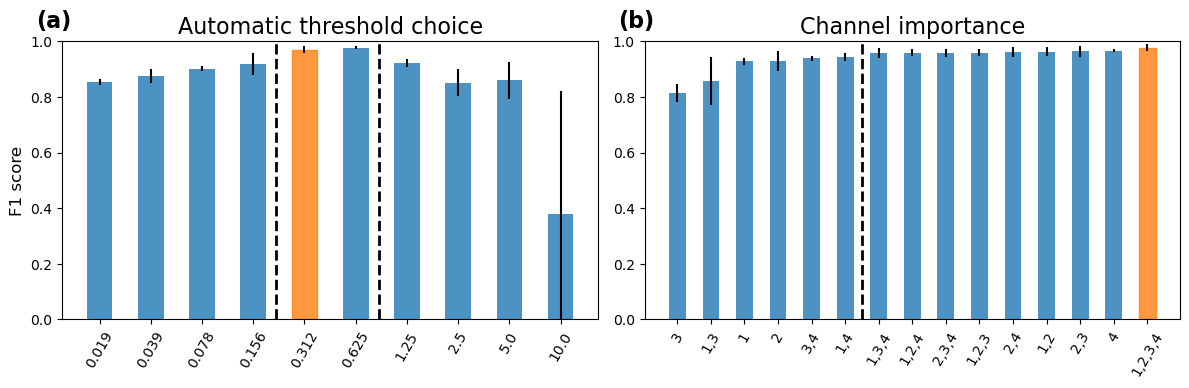

In [32]:
# ------ Main Fig. 4 ------

ticks = ['concentration_th', 'channels']
plot_titles = ['Automatic threshold choice', 'Channel importance']
channel_rename = {'CellMask': '1', 'mCherry': '2', 'A488': '3', 'DAPI': '4'}


thresholds_df = pd.read_csv('../data/Experiment2.csv', sep='\t')
channels_df = pd.read_csv('../data/Experiment3.csv', sep='\t')

dfs = [thresholds_df, channels_df]

fig, ax = plt.subplots(1, 2, figsize=(fig_length, 4))
for i in range(len(dfs)):
    df_s = dfs[i]
    x_tick = list(df_s[ticks[i]].values)

    n_groups = 1
    width = 1 / (n_groups + 1)  # the width of the bars
    multiplier = 0
    x = np.arange(len(x_ticks[i]))  # the label locations
    means = []
    errs = []
    offset = width * multiplier + width / 2
    for tick in x_tick:
        tick_df = df_s[df_s[ticks[i]] == tick]
        m = tick_df['mean'].values[0]
        s = tick_df['std'].values[0]
        means.append(m)
        errs.append(s)

    if i == 1:
        x_tick_number = []
        for tick in x_tick:
            tick = tick.split(',')
            tick = [channel_rename[x] for x in tick]
            tick = ','.join(tick)
            x_tick_number.append(tick)

        # sort the channels by the f1-score
        new_channel_order = [(x, y, z, a) for (x, y, z, a) in zip(x_tick, x_tick_number, means, errs)]
        new_sorted_channels = sorted(new_channel_order, key=lambda x: x[2])
        x_tick, new_ticks, means, errs = zip(*new_sorted_channels)
        x_tick = new_ticks
    elif i == 0:
        ax[i].set_ylabel('F1 score', fontsize=label_fontsize)

    bars = ax[i].bar(x + offset, means, width, yerr=errs, label=label_name, alpha=0.8)
    multiplier += 1
    
    if i == 1:
        # change color of target
        idx = x_tick.index('1,2,3,4')
        bars[idx].set_color(plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
        # add significance line
        ax[i].axvline(x=5.75, color='black', linestyle='--', linewidth=2)
    elif i == 0:
        # change color of target
        idx = x_tick.index(0.312)
        bars[idx].set_color(plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
        # add significance lines
        ax[i].axvline(x=3.7, color='black', linestyle='--', linewidth=2)
        ax[i].axvline(x=5.7, color='black', linestyle='--', linewidth=2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[i].set_xticks(x + (width * n_groups) / 2, x_tick, rotation=60, fontsize=tick_fontsize)
    ax[i].tick_params(axis='y', labelsize=tick_fontsize)
    ax[i].set_title(plot_titles[i], fontsize=title_fontsize)
    ax[i].text(-0.05, 1.05, letters[i], transform=ax[i].transAxes, size=16, weight='bold')
    ax[i].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(f'../plots/Fig4.pdf', dpi=300)
plt.show()
plt.close()

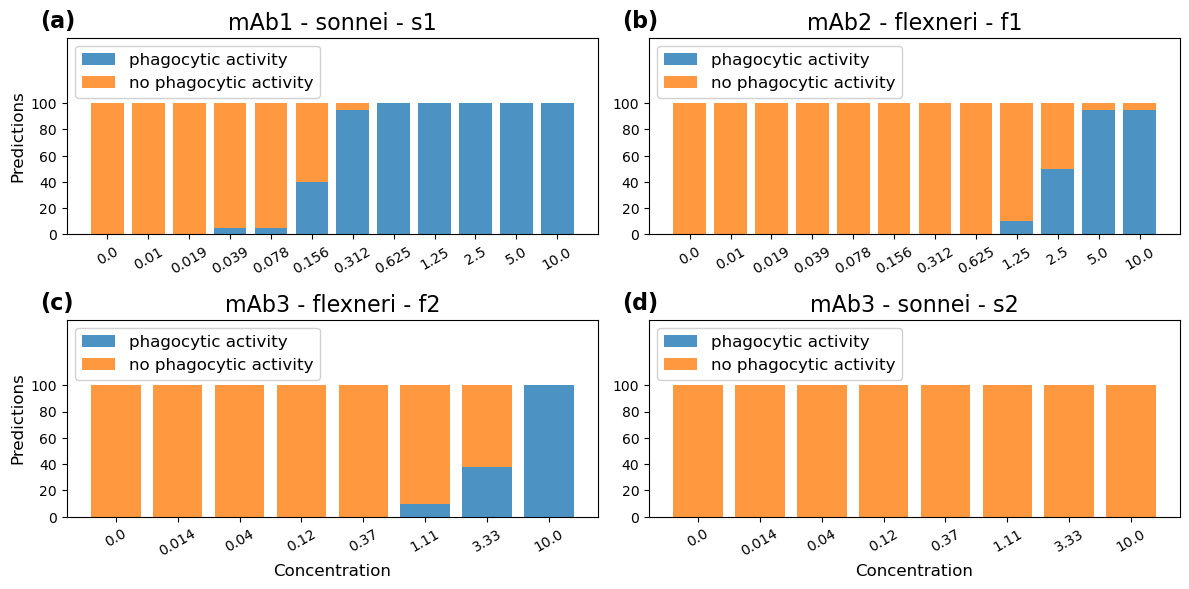

In [36]:
# ------ Main Fig. 5 ------

df = pd.read_csv('../data/InferenceResults.csv', sep='\t')


experiments = sorted(df['experiment'].unique())

# tests for Fig. 5
tests = [
    {'treatment': 'mAb1', 'strain':'s1'},
    {'treatment': 'mAb2', 'strain':'f1'},
    {'treatment': 'mAb3', 'strain':'f2'},
    {'treatment': 'mAb3', 'strain':'s2'},
 ]


max_y = 150
fig, ax = plt.subplots(2, 2, figsize=(fig_length, 6))
for i, test in enumerate(tests):
    mab = test['treatment']
    strain = test['strain']
    df_mab = df[(df['strain'] == strain) & (df['treatment'] == mab)]
    species = df_mab['species'].unique()[0]
    concentrations = sorted(df_mab['concentration'].unique())

    # count the number of positive and negative prediction for each concentration
    grouped = df_mab.groupby('concentration').agg(count=('concentration', 'size'),prediction=('prediction', 'sum')).reset_index()
    
    negative_predictions = list(grouped['count'] - grouped['prediction'])
    positive_predictions = list(grouped['count'] - negative_predictions)
    negative_predictions = [100*negative_predictions[i]/grouped['count'][i] for i in range(len(negative_predictions))]
    positive_predictions = [100*positive_predictions[i]/grouped['count'][i] for i in range(len(positive_predictions))] 

    x = np.arange(len(concentrations))
    # plot the bars
    ax[i//2, i%2].bar(x, positive_predictions, label='phagocytic activity', alpha=0.8)
    ax[i//2, i%2].bar(x, negative_predictions, bottom=positive_predictions, label='no phagocytic activity', alpha=0.8)
    
    # x_ticks and labels
    ax[i//2, i%2].set_xticks(x, concentrations, rotation=30, fontsize=tick_fontsize)
    if i > 1:
        ax[i//2, i%2].set_xlabel('Concentration', fontsize=label_fontsize)
    
    # y_ticks and labels
    y_ticks = list(range(0, max_y, 20))
    y_ticks = [tick for tick in y_ticks if tick<101]
    ax[i//2, i%2].set_yticks(y_ticks, y_ticks, fontsize=tick_fontsize)
    if i%2 == 0:
        ax[i//2, i%2].set_ylabel('Predictions', fontsize=label_fontsize)

    ax[i//2, i%2].set_ylim([0, max_y])
    
    ax[i//2, i%2].text(-0.05, 1.05, letters[i], transform=ax[i//2, i%2].transAxes, size=16, weight='bold')
    ax[i//2, i%2].set_title(f'{mab} - {species} - {strain}', fontsize=title_fontsize)
    ax[i//2, i%2].legend(loc = 'upper left', framealpha=0.9, fontsize=label_fontsize)


plt.tight_layout()
plt.savefig(f'../plots/Fig5.pdf', dpi=300, bbox_inches='tight')

plt.show()
plt.close()


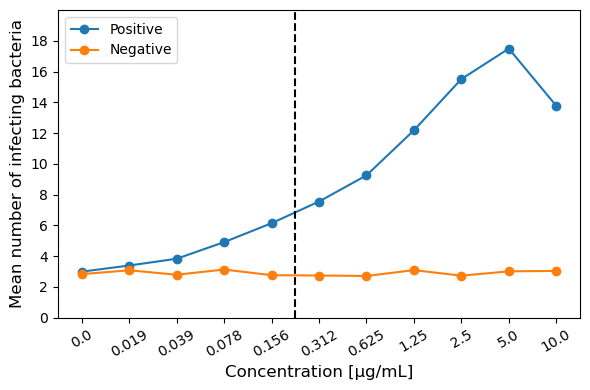

In [37]:
# ------ Supplementary Fig. 1 ------
df = pd.read_csv('../data/MeanNumberInfectingBacteria.csv', sep='\t')

fig, ax = plt.subplots(figsize=(fig_length/2, 4))

ax.plot(range(len(df['concentrations'])), df['positive'], marker='o', label='Positive')
ax.plot(range(len(df['concentrations'])), df['negative'], marker='o', label='Negative')

ax.set_xlabel('Concentration [μg/mL]', fontsize=label_fontsize)
ax.set_xticks(range(len(df['concentrations'])), [str(c) for c in df['concentrations']], fontsize=tick_fontsize, rotation=30)

ax.set_ylabel('Mean number of infecting bacteria', fontsize=label_fontsize)
ax.set_yticks(range(0,20,2), range(0,20,2), fontsize=tick_fontsize)
ax.set_ylim([0, 20])

ax.axvline(x=4.5, color='k', linestyle='--')
ax.legend(fontsize=tick_fontsize)

plt.tight_layout()

# save figure
plt.savefig('../plots/S1.pdf', dpi=300, bbox_inches='tight')

plt.show()
plt.close()
